## test.ipynb: Test the training result and Evaluate model

In [1]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral

Using TensorFlow backend.


In [2]:
# Define the neccesary functions for later use
# load the Indian pines dataset which is the .mat format
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'data')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines.mat'))['indian_pines']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

In [3]:
#  load the Indian pines dataset which is HSI format
#  refered from http://www.spectralpython.net/fileio.html
def loadHSIData():
    data_path = os.path.join(os.getcwd(), 'HSI_data')
    data = spectral.open_image(os.path.join(data_path, '92AV3C.lan')).load()
    data = np.array(data).astype(np.int32)
    labels = spectral.open_image(os.path.join(data_path, '92AV3GT.GIS')).load()
    labels = np.array(labels).astype(np.uint8)
    labels.shape = (145, 145)
    return data, labels

In [4]:
# Get the model evaluation report, 
# include classification report, confusion matrix, Test_Loss, Test_accuracy
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']
def reports(X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy

In [5]:
# apply PCA preprocessing for data sets
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [6]:
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [7]:
# Global Variables
windowSize = 5
numPCAcomponents = 30
testRatio = 0.50

# show current path
PATH = os.getcwd()
print (PATH)

/home/danquxunhuan/course/prml/lab2/Indian_pines_classification


In [8]:
# Read PreprocessedData from file

X_test = np.load("./predata/XtestWindowSize" 
                 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
y_test = np.load("./predata/ytestWindowSize" 
                + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

# X_test = np.load("./predata/XAllWindowSize" 
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
# y_test = np.load("./predata/yAllWindowSize" 
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [9]:
# load the model architecture and weights
model = load_model('./model/HSI_model_epochs100.h5')

# calculate result, loss, accuray and confusion matrix
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion_str = str(confusion)

# show result and save to file
print('Test loss {} (%)'.format(Test_loss))
print('Test accuracy {} (%)'.format(Test_accuracy))
print("classification result: ")
print('{}'.format(classification))
print("confusion matrix: ")
print('{}'.format(confusion_str))
file_name = './result/report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('Test loss {} (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('Test accuracy {} (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write(" classification result: \n")
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write(" confusion matrix: \n")
    x_file.write('{}'.format(confusion_str))

5183/5183 [==============================] - 0s 75us/step
Test loss 8.111980778137243 (%)
Test accuracy 97.99344009261046 (%)
classification result: 
                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        27
                 Corn-notill       0.99      0.96      0.97       717
                Corn-mintill       0.97      0.96      0.96       417
                        Corn       0.91      0.98      0.94       117
               Grass-pasture       1.00      0.99      0.99       248
                 Grass-trees       0.99      1.00      1.00       374
         Grass-pasture-mowed       1.00      1.00      1.00        13
               Hay-windrowed       1.00      1.00      1.00       244
                        Oats       1.00      1.00      1.00        10
              Soybean-notill       0.97      0.97      0.97       484
             Soybean-mintill       0.98      0.98      0.98      1234
         

Confusion matrix, without normalization
[[  27    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0  689    5    0    0    0    0    0    0    2   18    0    0    2
     1    0]
 [   0    1  400   10    0    1    0    0    0    4    1    0    0    0
     0    0]
 [   0    2    0  115    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    2  245    0    0    0    0    0    0    0    0    1
     0    0]
 [   0    0    0    0    0  374    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0   13    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  244    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   10    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    2    0    0    0  470    6    4    0    1
     1    0]
 [   0    5    7    0    1    0    0    0    0    9 1210    2    0    0
     0    0]
 [   0    0    2    0    

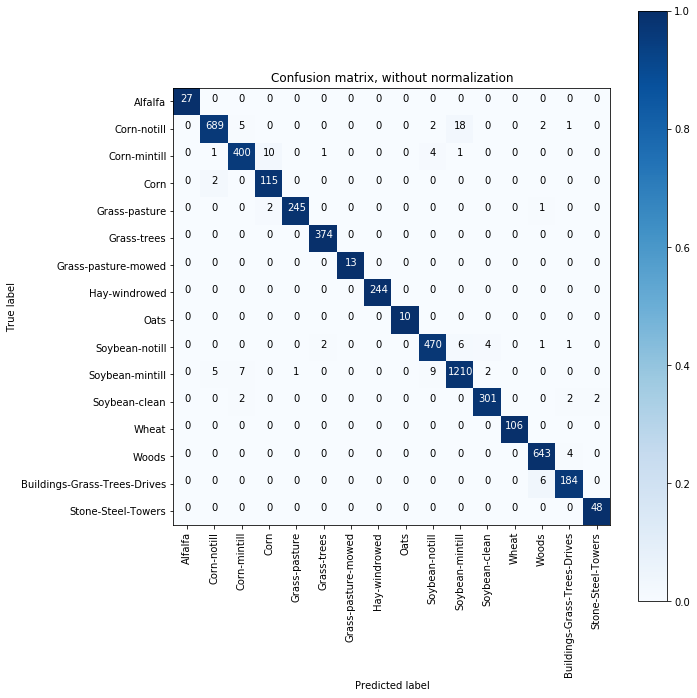

Normalized confusion matrix
[[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.60948396e-01   6.97350070e-03   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   2.78940028e-03   2.51046025e-02   0.00000000e+00
    0.00000000e+00   2.78940028e-03   1.39470014e-03   0.00000000e+00]
 [  0.00000000e+00   2.39808153e-03   9.59232614e-01   2.39808153e-02
    0.00000000e+00   2.39808153e-03   0.00000000e+00   0.00000000e+00
    0.00000000e+00   9.59232614e-03   2.39808153e-03   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.70940171e-02   0.00000000e+00   9.82905983e-01
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00

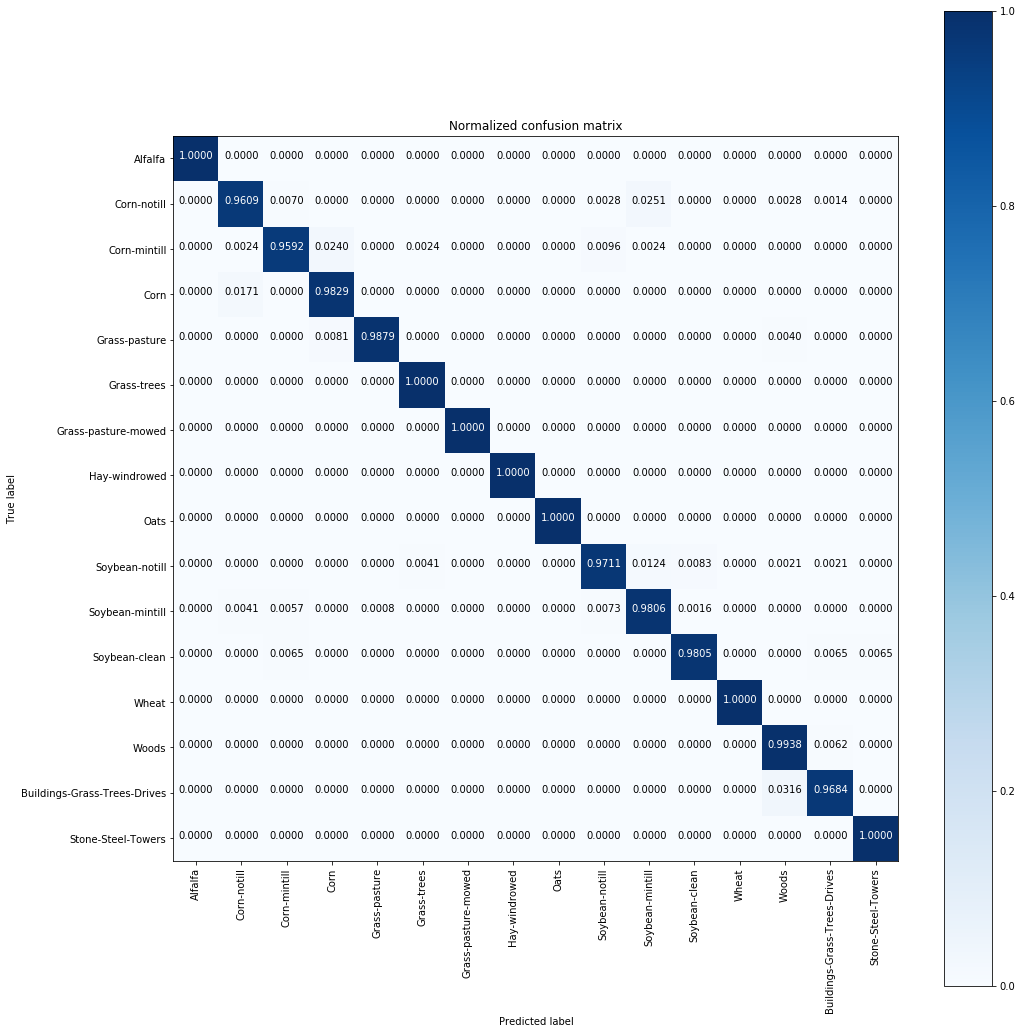

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.get_cmap("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if normalize:
        cm = Normalized
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(Normalized, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        thresh = cm[i].max() / 2.
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion, classes=target_names, normalize=False, 
                      title='Confusion matrix, without normalization')
plt.savefig("./result/confusion_matrix_without_normalization.svg")
plt.show()
plt.figure(figsize=(15,15))
plot_confusion_matrix(confusion, classes=target_names, normalize=True, 
                      title='Normalized confusion matrix')
plt.savefig("./result/confusion_matrix_with_normalization.svg")
plt.show()

In [11]:
# load the original image
# X, y = loadIndianPinesData()
X, y = loadHSIData()
X, pca = applyPCA(X, numComponents=numPCAcomponents)

/home/danquxunhuan/software/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """
/home/danquxunhuan/software/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  import sys


In [12]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 5
numComponents = 30

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        p = int(PATCH_SIZE/2)
        # print(y[i+p][j+p])
        # target = int(y[i+PATCH_SIZE/2, j+PATCH_SIZE/2])
        target = y[i+p][j+p]
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            # print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[i+p][j+p] = prediction+1

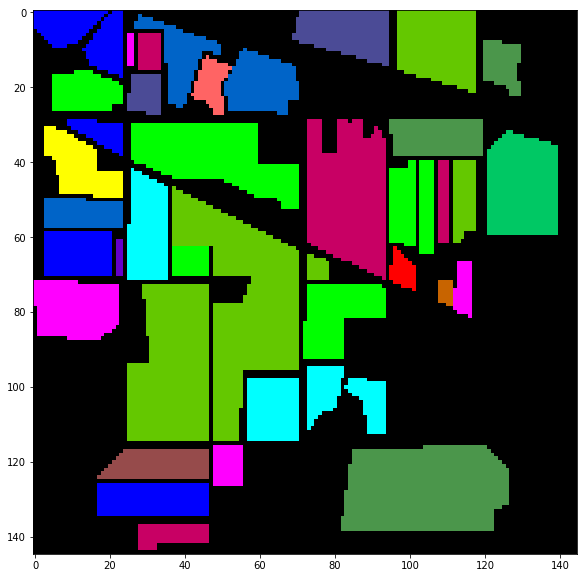

In [13]:
ground_truth = spectral.imshow(classes=y, figsize=(10, 10))

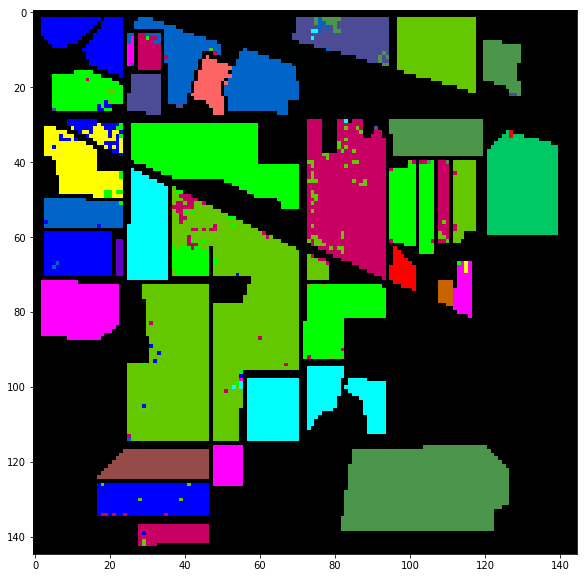

In [14]:
predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(10, 10))